# Nonce Distribution Study
Noncesense Research Lab / Monero Archival Project

Nov 2018

This is a "noncesense" study into the empirically observed distribution of nonces in the Monero blockchain between the genesis block and height 1660413.

# Contributors
-  Data: [NeptuneResearch](https://github.com/neptuneresearch)
-  Analysis: [Isthmus](https://github.com/mitchellpkt)


# Before reading this notebook...

... pause for a moment and consider what you would expect to see.

Miners test random nonce values between 0 and 2^32 to find one that produces a hash digest with output value below some threshhold defined by the network difficulty.

For any given block, acceptable nonces are scattered throughout the allowed range, which miners are *presumably* sampling at random. So what patterns (or lack thereof) would you expect in the actual list of nonces reported on the blockchain?

# Analysis

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import mlab
import matplotlib.pyplot as plt
from scipy.stats import norm
import random
import matplotlib.patches as patches

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import data

In [3]:
df = pd.read_csv("./data/nonce_0_to_1753719.csv") # switch to os.join 
df.describe()

,id,nonce
count,1.753702e+06,1.753702e+06
mean,8.768519e+05,9.013243e+08
std,5.062510e+05,1.334241e+09
min,1.000000e+00,0.000000e+00
25%,4.384262e+05,4.369000e+03
50%,8.768515e+05,1.589950e+05
75%,1.315277e+06,1.718006e+09
max,1.753719e+06,4.294967e+09


## Plot the distribution of nonce values

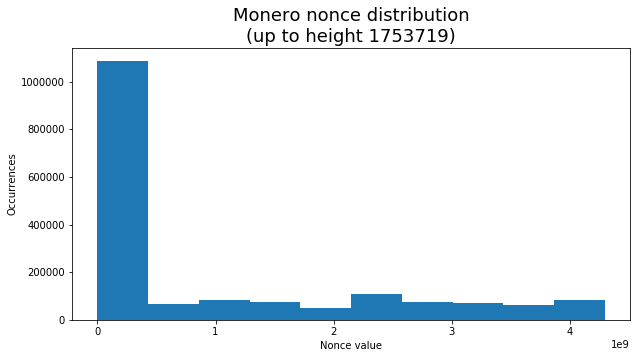

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.hist(df.nonce,bins=10);
plt.title('Monero nonce distribution\n(up to height 1753719)');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

### ^ That is not uniform!
The above plot shows that the vast majority of nonce values are at the low end of the range.

Let's zoom in on the nonce values on [0, 10^4]

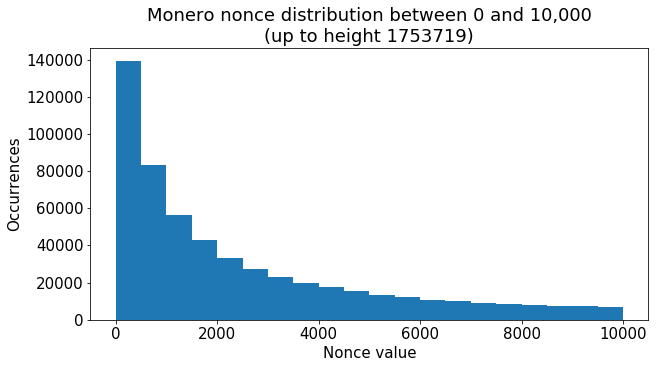

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.hist(df.nonce[df.nonce<1e4], bins=20);
plt.title('Monero nonce distribution between 0 and 10,000\n(up to height 1753719)');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

Observed nonce values are heavily concentrated toward the lower end of the allowed range! This is NOT what one would expect. 

Let's take a quick peek at the cumulative distribution function:

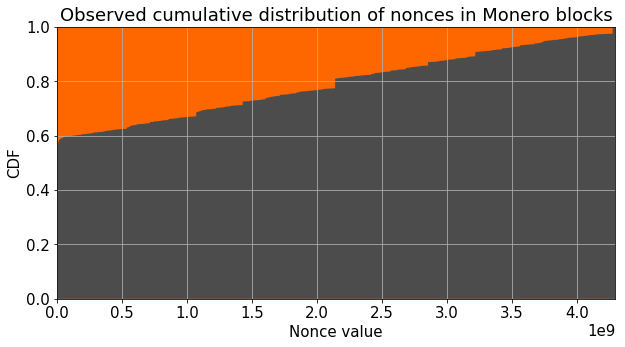

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
bin_edges = bins=np.logspace(np.log10(1),np.log10(4294967296), 5000)

# plot the cumulative histogram
n, bins, patches = ax.hist(df.nonce, bins=bin_edges, density=1, histtype='stepfilled',
                           cumulative=True, color=(76/256,76/256,76/256))

ax.set_facecolor((255/256,102/256,0/256))
ax.grid(True)
ax.set_title('Observed cumulative distribution of nonces in Monero blocks')
ax.set_xlabel('Nonce value')
ax.set_ylabel('CDF')
ax.set_xscale('linear')
ax.set_xlim(1,4294967296)
ax.set_ylim(0,1)
plt.show()

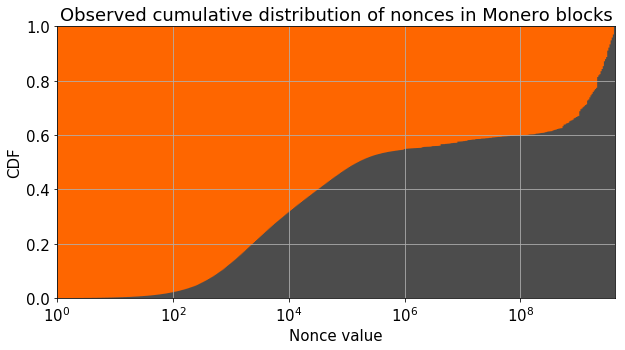

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
bin_edges = bins=np.logspace(np.log10(1),np.log10(4294967296), 500)

# plot the cumulative histogram
n, bins, patches = ax.hist(df.nonce, bins=bin_edges, density=1, histtype='stepfilled',
                           cumulative=True, color=(76/256,76/256,76/256))

ax.set_facecolor((255/256,102/256,0/256))
ax.grid(True)
ax.set_title('Observed cumulative distribution of nonces in Monero blocks')
ax.set_xlabel('Nonce value')
ax.set_ylabel('CDF')
ax.set_xscale('log')
ax.set_xlim(1,4294967296)
ax.set_ylim(0,1)
plt.show()

## Observations

Despite a HUGE range of nonce values to choose from (between 1 and ~ 5x10^8) **more than half of the nonces on the blockchain come from the lowest 1% of the range that can be sampled!**

Two possible explanations:

Possibility 1: (UNLIKELY) There is a bias in the distribution of acceptable nonce values. This is logically unlikely since the hash function probably has "good" properties and PoW uses the hash of the block contents alongside the nonce.

Possibility 2: Miners are not sampling the space of nonce values randomly.

Possibility two seems more likely. (insert links to code)

## Looking at other predictable 'random' search 
Let's take a closer look at the overall plot of the search space for nonces.

Above, we investigated (zoomed into) the excess of nonces at very low values. However, notice in the below plot that there are also some bumps near the middle and other end

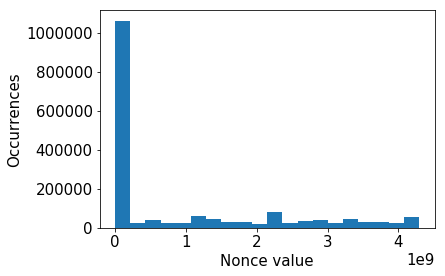

In [8]:
plt.rcParams.update({'font.size': 15})
plt.hist(df.nonce,bins=20);
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

### Control case

Plot a random window, will probably see a uniform distribution

3280387013


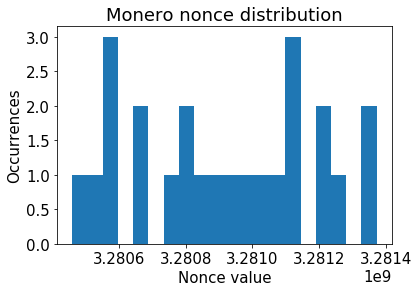

In [9]:
random.seed(1)
random_val = random.randint(1,2**32)
print(random_val)
window = 1e6
nonces = list(df.nonce)
subset = [nonce for nonce in nonces if nonce > random_val and nonce < (random_val + window)]
plt.hist(subset, bins=20);
plt.title('Monero nonce distribution');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

### Start at the maximum nonce value (2^32) and work backwards
Instead of testing nonces from 0 and increasing upwards, some software starts at the maximum value and tests backwards.

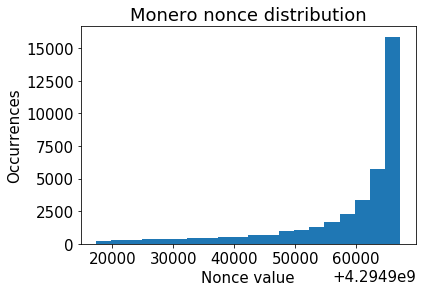

In [10]:
window = 5e4
max_val = 2**32
nonces = list(df.nonce)
subset = [nonce for nonce in nonces if nonce > (max_val - window)]
plt.hist(subset, bins=20);
plt.title('Monero nonce distribution');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

### Start at the halfway point and count upwards
Some software also starts at the middle and counts upward

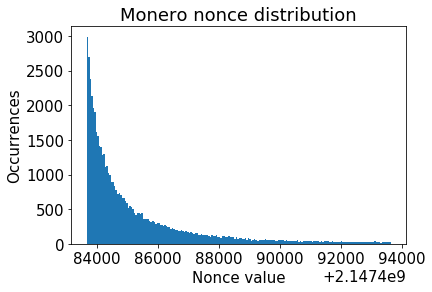

In [11]:
halfway_val = (2**32)/2;
window = 1e4
nonces = list(df.nonce)
subset = [nonce for nonce in nonces if nonce > halfway_val and nonce < (halfway_val + window)]
plt.hist(subset, bins=200);
plt.title('Monero nonce distribution');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

## Time dependence

Inspired by:

__Antoine Le Calvez__

@khannib https://twitter.com/khannib/status/1082280569449447424

In [12]:
pow_tweak_fork_height = 1546000

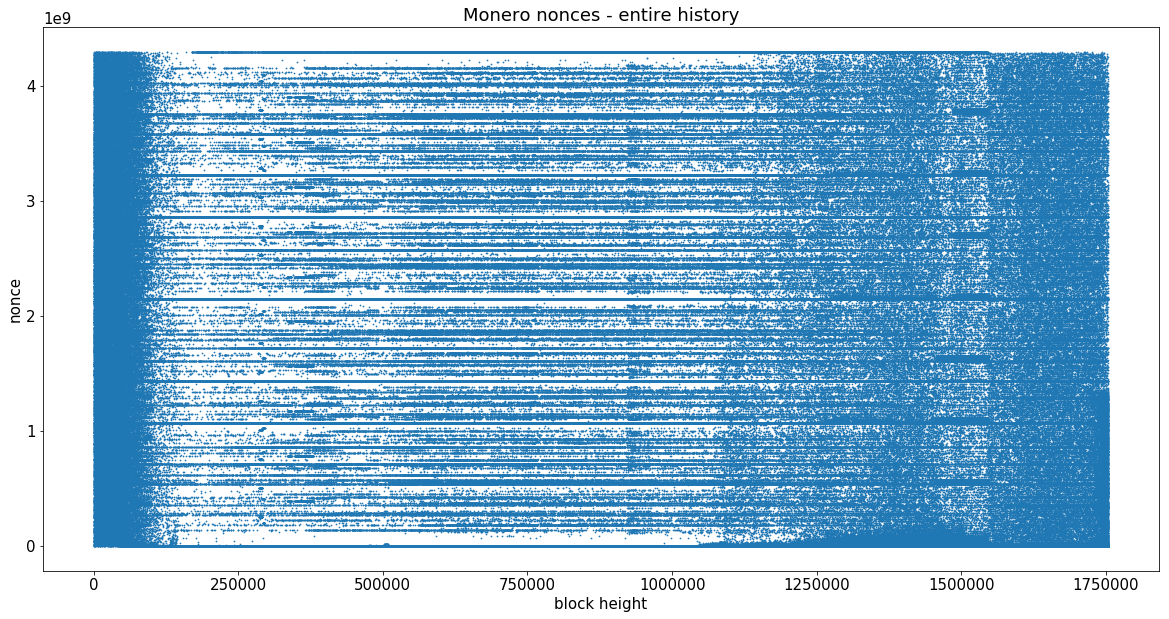

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(df.id, df.nonce, s=0.5)
plt.title('Monero nonces - entire history')
plt.xlabel('block height')
plt.ylabel('nonce')
plt.show()

Okay, now let's take a peek for the trend spotted by:

# orbit33

https://www.reddit.com/r/Monero/comments/agysnf/hashrate_discussion_thread/ef45idn

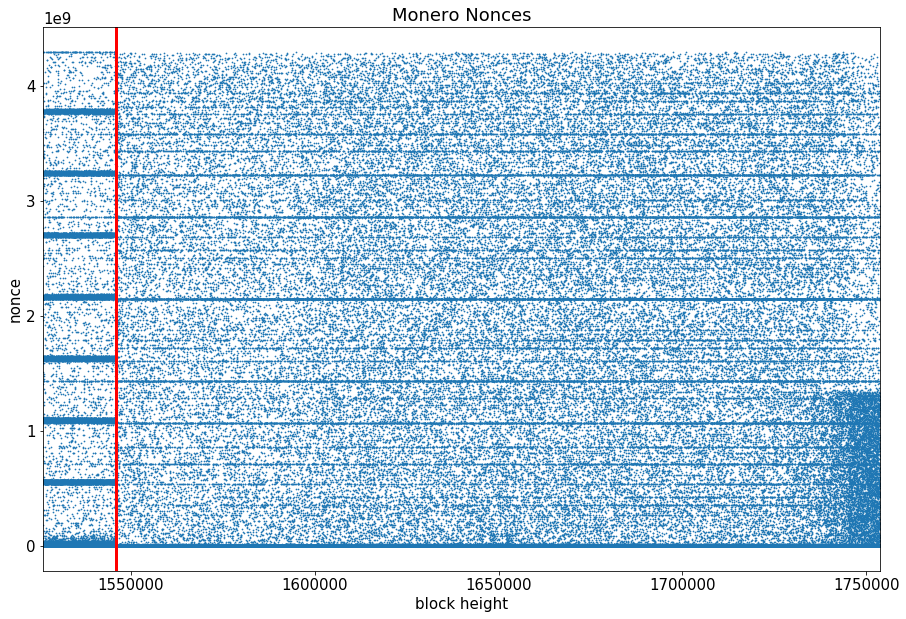

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
min_height = pow_tweak_fork_height-2e4
x = df.id[df.id>min_height]
y = df.nonce[df.id>min_height]
plt.scatter(x,y, s=0.5)
plt.title('Monero Nonces')
plt.xlabel('block height')
plt.ylabel('nonce')
plt.axvline(x=pow_tweak_fork_height, c='red', linewidth=3)
# plt.axhline(y=1.35e9, c='black', linewidth=3)
ax.set_xlim(min_height,max(df.id))
plt.show()

^^ Yep, there it is! Definitely something unusual happening...

### Xiphon
And let's combine it with the network hashrate data derived from block difficulty

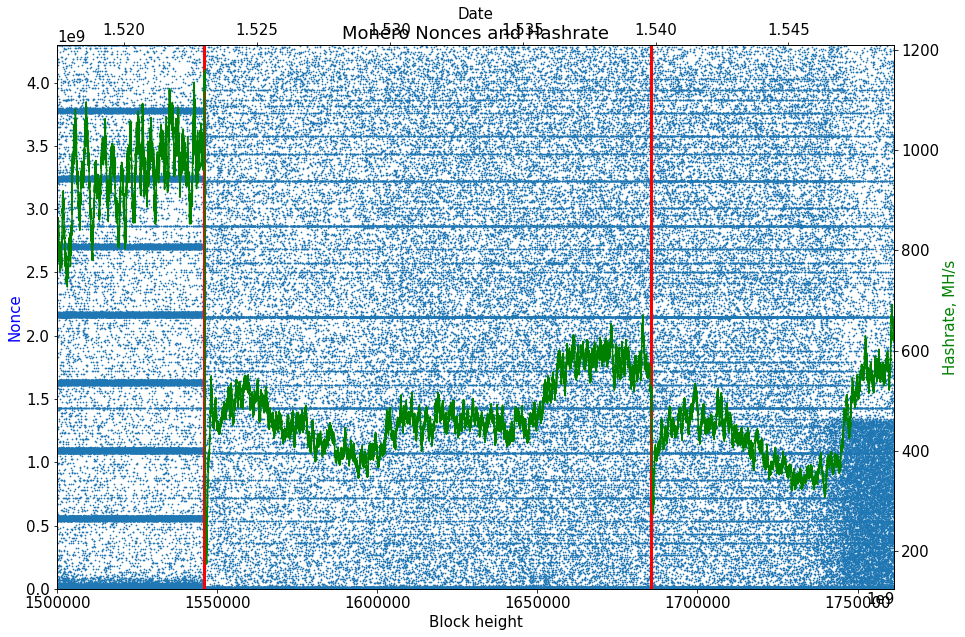

In [15]:
data = pd.read_csv("./data/nonce-difficulty-1500000-1761389.csv")

pow_v7_fork_height = 1546000
pow_v8_fork_height = 1685555
block_time_sec = 120

fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(data.height, data.nonce, s=0.5)
plt.title('Monero Nonces and Hashrate')
plt.xlabel('Block height')
plt.ylabel('Nonce', color='blue')
plt.axvline(x=pow_v7_fork_height, c='red', linewidth=3)
plt.axvline(x=pow_v8_fork_height, c='red', linewidth=3)
ax.set_xlim(min(data.height), max(data.height))
ax.set_ylim(0, 2**32)

ax2 = ax.twinx()
hashrate_mh_s = data.difficulty*1e-6/block_time_sec
ax2.plot(data.height, hashrate_mh_s, 'green')
ax2.set_ylabel('Hashrate, MH/s', color='green')

ax3 = ax.twiny()
ax3.set_xlabel("Date")
ax3.set_xlim(min(data.timestamp), max(data.timestamp))

plt.show()

Let's get a 2D histogram behind this for clarity. Snagging code from https://plot.ly/python/2D-Histogram/

Text(0,0.5,'Counts')

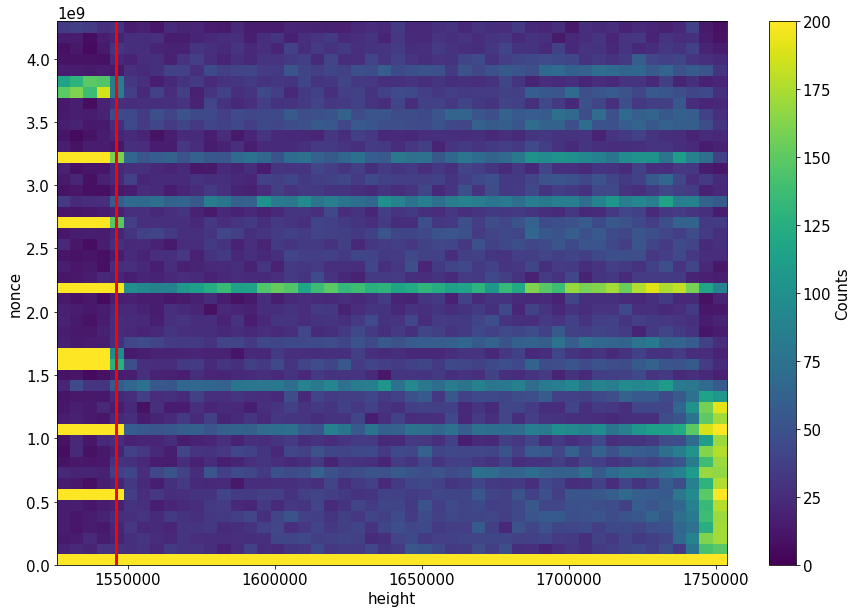

In [16]:
# Estimate the 2D histogram
nbins = (50,50)
H, xedges, yedges = np.histogram2d(x,y,bins=nbins)
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)

fig, ax = plt.subplots(figsize=(15, 10))

# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,H,vmax=200, vmin=0)
plt.xlabel('height')
plt.ylabel('nonce')
plt.axvline(x=pow_tweak_fork_height, c='red', linewidth=3)
cbar = plt.colorbar()

cbar.ax.set_ylabel('Counts')

^^ __The trend by u/obit33 is definitely real, and started around block 1745000 ~ 2019-01-09__

Lol, this phenomenon started around same time I published my article about [nonce distributions](https://hackernoon.com/utter-noncesense-a-statistical-study-of-nonce-value-distribution-on-the-monero-blockchain-f13f673a0a0d).

Okay, let's zoom in and watch the vacuum form

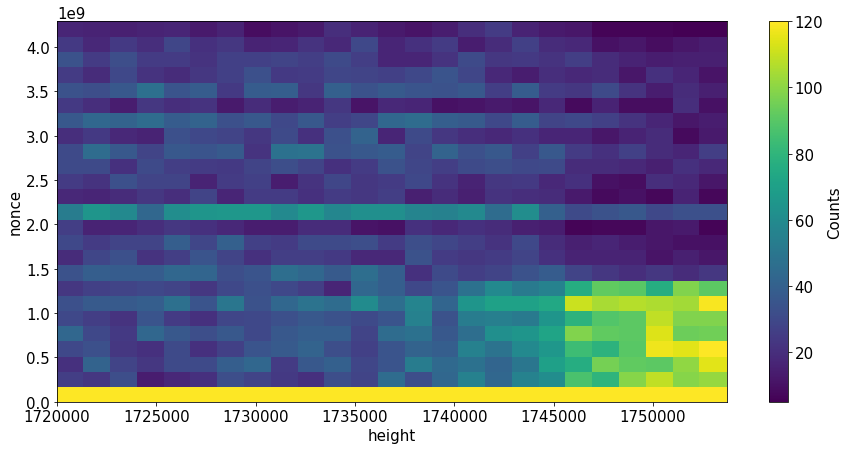

In [17]:
min_height = 1720000
x = df.id[df.id>min_height]
y = df.nonce[df.id>min_height]
# Estimate the 2D histogram
nbins = (25,25)
H, xedges, yedges = np.histogram2d(x,y,bins=nbins)
 
# H needs to be rotated and flipped
H = np.rot90(H)
H = np.flipud(H)

fig, ax = plt.subplots(figsize=(15,7))

# Plot 2D histogram using pcolor
plt.pcolormesh(xedges,yedges,H,vmax=120)
plt.xlabel('height')
plt.ylabel('nonce')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Counts');

You can actually see the upper part of the nonce range quiet down when the noise starts below 1.35e9

Streakiness in new signal?

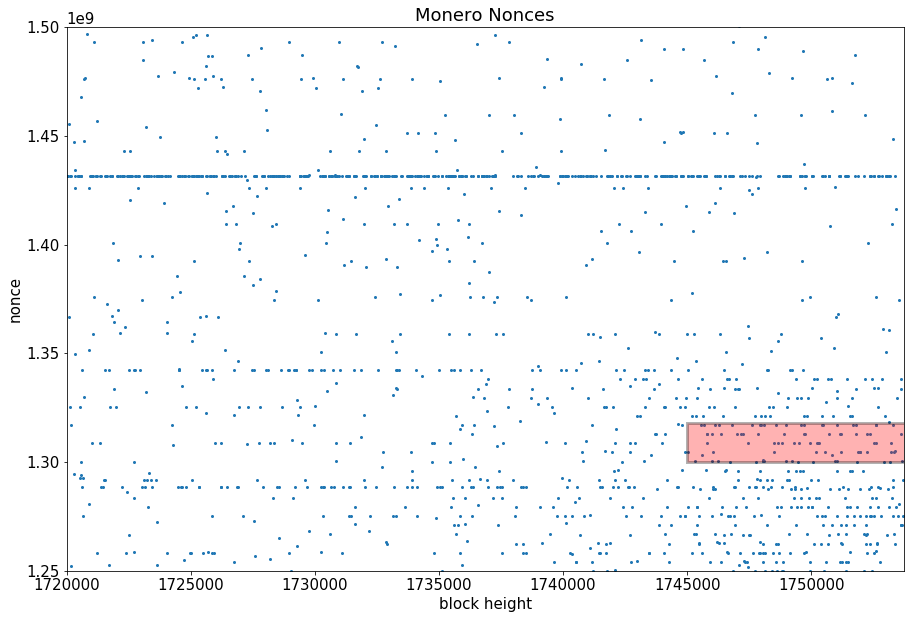

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(x,y, s=4)
plt.title('Monero Nonces')
plt.xlabel('block height')
plt.ylabel('nonce')
# plt.axhline(y=1.35e9, c='black', linewidth=3)
ax.set_xlim(min_height,max(df.id))
ax.set_ylim(1.25e9, 1.5e9)

## Show the area that we will study for histogram
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# on the run, I'll deal with imports later

min_nonce_val = 1.3e9
nonce_window = 0.018e9
new_trend_h = 1745000

# Add rectangle
ax.add_patch(
patches.Rectangle(
(new_trend_h, min_nonce_val), # (x,y)
nonce_window-max(df.id), # width
nonce_window, # height
# You can add rotation as well with 'angle'
alpha=0.3, facecolor="red", edgecolor="black", linewidth=3, linestyle='solid'
)
)

plt.show()

It's evenly spaced between 0 and ~ 1.34e9 (not precisely)

Below is a histogram of nonces in the area that I highlighted in red above.

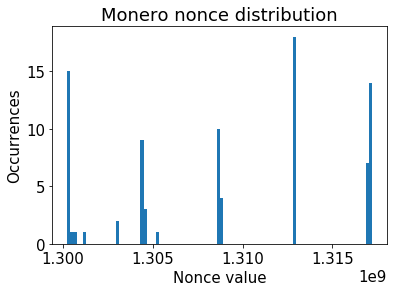

In [19]:
recent_nonces = df.nonce[df.id>1745000]
subset = [nonce for nonce in recent_nonces if nonce > min_nonce_val and nonce < min_nonce_val+nonce_window]
plt.hist(subset, bins=100);
plt.title('Monero nonce distribution');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

This will probably be easier if we drop the x offset

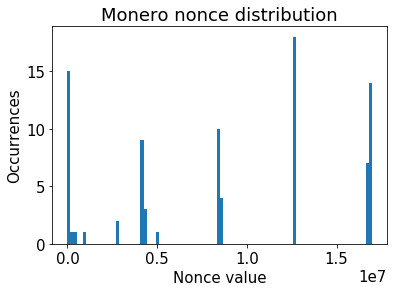

In [20]:
xoffset = min(subset)
subset0 = [s-xoffset for s in subset]
plt.hist(subset0, bins=100);
plt.title('Monero nonce distribution');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

Run below cell for a verbose text output. 

__TL;DR is that the peaks are spaced out by about 4193067__

In [21]:
# sorted(subset0)

In [22]:
approx_spacing = 4190428
window_mult = np.floor(min_nonce_val/approx_spacing)

## Okay, let's really nail down that value

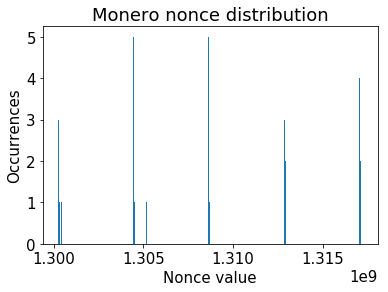

In [23]:
recent_nonces = df.nonce[df.id>1745000]
subset = [nonce for nonce in recent_nonces if nonce > min_nonce_val and nonce < min_nonce_val+nonce_window]
plt.hist(subset, bins=1000);
plt.title('Monero nonce distribution');
plt.ylabel('Occurrences');
plt.xlabel('Nonce value');

In [24]:
# Sort the list
nonce_subset = [int(x) for x in subset]
nonce_subset.sort(key=int)
ln = len(nonce_subset)

In [25]:
start_wrap = int(4100000)
wrap_window = int(300000)
std_dev_record = np.zeros(wrap_window-1)
c = 0

for wrap in range(start_wrap, start_wrap + wrap_window-1):
    wrapped_data = [np.mod(x,wrap) for x in nonce_subset]
    std_dev = np.std(np.mod(nonce_subset, wrapped_data))
    std_dev_record[c] = std_dev
    c = c + 1


/home/m/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in remainder
  


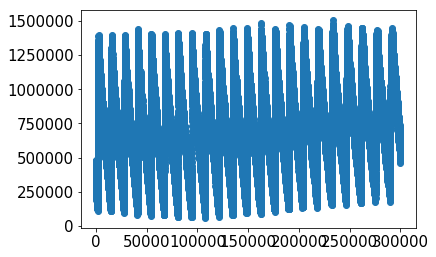

In [26]:
plt.scatter(range(len(std_dev_record)), std_dev_record)

In [27]:
min_std = min(std_dev_record)
[i for i, j in enumerate(std_dev_record) if j == min_std]

[107531]